In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create 4 simple recognizable 10x10 patterns (letters/numbers/shapes)
img_dim = 10
patterns = []

# Pattern 1: X shape
X = -np.ones((img_dim,img_dim))
for i in range(img_dim):
    X[i,i] = 1
    X[i,9-i] = 1
patterns.append(X)

# Pattern 2: O shape (circle-like border)
O = -np.ones((10,10))
O[0,:] = 1
O[-1,:] = 1
O[:,0] = 1
O[:,-1] = 1
patterns.append(O)

# Pattern 3: Checkerboard
checker = np.fromfunction(lambda i, j: ((i + j) % 2) * 2 - 1, (img_dim,img_dim))
patterns.append(checker)

# Pattern 4: L shape
L = -np.ones((10,10))
L[:-2,1] = 1
L[-2,1:] = 1
patterns.append(L)

patterns = np.array(patterns)

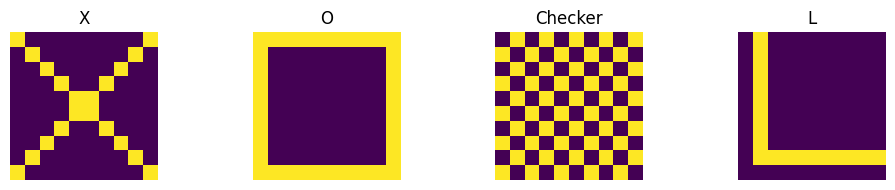

In [3]:
# Display patterns
fig, axes = plt.subplots(1, 4, figsize=(10,2))
axes = axes.flatten()
titles = ["X", "O", "Checker", "L"]

for i in range(4):
    axes[i].imshow(patterns[i], interpolation='nearest')
    axes[i].set_title(titles[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
class Neuron:
    def __init__(self, index, bias=0.0):
        self.index = index
        self.bias = bias
        self.state = np.random.choice(np.array([1,-1]))  # +1/-1 for Hopfield

    def update_state(self, input_sum, stochastic=False, temperature=1.0):
        if not stochastic:  # Hopfield
            self.state = 1 if input_sum >= 0 else -1
        else:  # For Boltzmann/RBM later
            prob = 1 / (1 + np.exp(-input_sum / temperature))
            self.state = 1 if np.random.rand() < prob else 0

In [5]:
class HopfieldNetwork:
    def __init__(self, n_neurons):
        self.neurons = [Neuron(i) for i in range(n_neurons)]
        self.W = np.zeros((n_neurons, n_neurons))

    def train(self, patterns):
        '''This function sculpts the energy landscape'''
        patterns = np.array(patterns)
        for p in patterns:
            p = p.reshape(-1, 1)
            self.W += p @ p.T

        np.fill_diagonal(self.W, 0)
        self.W /= len(patterns)

    def update(self, async_update=True, steps=10):
        n = len(self.neurons)
        for _ in range(steps):
            if async_update:
                i = np.random.randint(n)
                self._update_neuron(i)
            else:
                for i in range(n):
                    self._update_neuron(i)

    def _update_neuron(self, i):
        neuron = self.neurons[i]
        # Weighted input sum
        input_sum = np.dot(self.W[i], [n.state for n in self.neurons]) + neuron.bias
        neuron.update_state(input_sum)

    def get_state(self):
        return np.array([n.state for n in self.neurons])

In [6]:
net = HopfieldNetwork(100)

flat_patterns = [p.flatten() for p in patterns]
net.train(flat_patterns)

In [7]:
# Corrupted input
corrupt_input = L
corrupt_input[:,:2] = 1

In [8]:
for i, v in enumerate(corrupt_input.flatten()):
    net.neurons[i].state = v

net.update(async_update=True, steps=500)

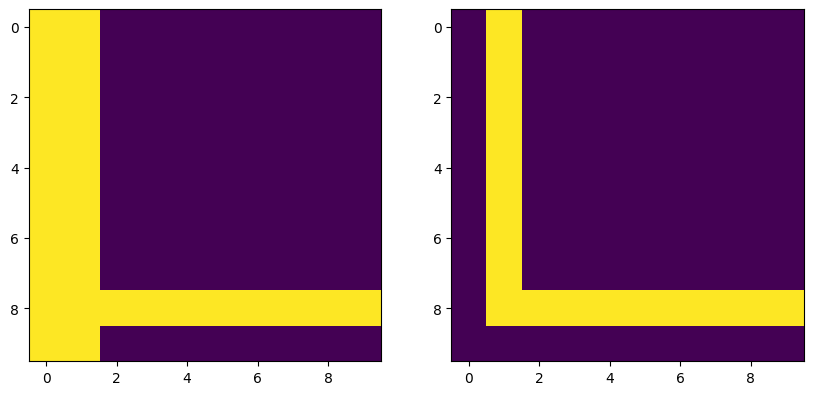

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.imshow(corrupt_input.reshape((img_dim,img_dim)))
ax2.imshow(net.get_state().reshape((img_dim,img_dim)))
plt.show()